In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_results(n_ctxs):
    with open('../../results/proportion_results_mlp_wine_%sctx.P' %(n_ctxs), 'rb') as f:
        results = pickle.load(f)
    results = results['proportion_results']
    return results

In [3]:
def plot_pie_bar_chart(pies):
    n_ctxs = pies.shape[0]
    n_hidd = pies.shape[1]
    ctxs = np.zeros(n_ctxs+2) # ctxs[-1] refers to none, and ctxs[-2] to mixed

    for i in range(n_hidd):
        ctx = pies[:,i]
        if  not np.any(ctx):
            ctxs[-1]+=1
        elif np.sum(ctx)>1:
            ctxs[-2]+=1
        else:
            idx = np.where(ctx) # this finds which context is 1
            ctxs[idx]+=1
        
    labels = []
    for ctx in range(n_ctxs):
        labels.append('ctx%s' %(ctx))
    labels.append('mixed')
    labels.append('none')
    fig, axs = plt.subplots(1,2)
    ax = axs[0]
    ax.pie(ctxs, labels=labels)#, autopct='%1.1f%%')#, shadow=True)#, startangle=90)
    ax.axis('equal')

    ax = axs[1]
    model = 'mlp'
    for ctx in range(ctxs.shape[0]):
        ax.bar(model, ctxs[ctx], bottom = np.sum(ctxs[:ctx]))
    ax.legend(labels)
    plt.tight_layout()

    return fig, axs

In [37]:
n_ctxs=8
results = read_results(n_ctxs)


In [38]:
hiddens_ctxs = results['hiddens_ctxs'] # [run, checkpoints, n_ctxs, n_trials, hidd_dim]
p_pies = results['p_pies'] # [run, checkpoints, n_ctxs, hidd_dim]
ps = results['ps'] # [run, checkpoints, n_ctxs, hidd_dim]
n =  results['n'] # [run, checkpoints, n_ctxs, hidd_dim]
n_runs = n.shape[0]
n_cps = n.shape[1]
hidd_dim = n.shape[3]
print(n.shape)
print(ps.shape)

(20, 21, 8, 128)
(20, 21, 8, 128)


In [39]:
w_cp = -1 # last checkpoint, w stands for which 
w_run = 15
if w_run==-1:
    run_label = 'Last'
else:
    run_label = '#%s' %(w_run)

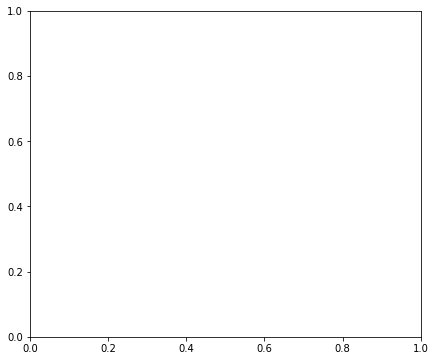

In [40]:
fig, axs = plt.subplots(figsize=[7,6])
if n_ctxs==2:
    ps = results['ps']
    ps = ps[:,w_cp,:,:]
    print(ps.shape)
    for run in range(n_runs):
        # colors shows different runs
        plt.scatter(ps[run][0], ps[run][1])
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel('Context1')
        plt.ylabel('Context2')
        fig.suptitle('2 Contexts - Multiple Runs', fontweight='bold')
        plt.tight_layout()
        fig_str = 'proportion_results_mlp_wine_scatter_%sctx' %(n_ctxs)
        fig.savefig(('../../figures/' + fig_str + '.pdf'), 
                    bbox_inches = 'tight', pad_inches = 0)

(8, 128)


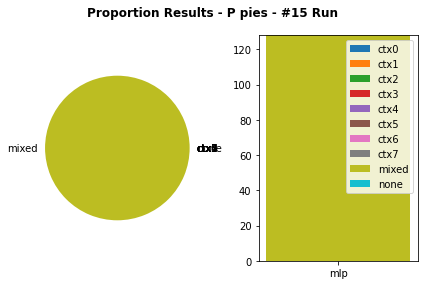

In [41]:
p_pies = results['p_pies']
p_pies = p_pies[w_run,w_cp,:,:]
print(p_pies.shape)

fig, axs = plot_pie_bar_chart(p_pies)
fig.suptitle('Proportion Results - P pies - %s Run' %(run_label), fontweight='bold')
plt.tight_layout()
fig_str = 'proportion_results_mlp_wine_p_pies_%sctx' %(n_ctxs)
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
        bbox_inches = 'tight', pad_inches = 0)
# hidden units selectivity 
# proportion of hidden units that were active at all (even one trial) for each context
# we have ... many hiddens that were active for both (mixed), ... many units that were active for ctx1, so on so forth

In [42]:
def calc_hidd_sens(hidds_act):
    n_runs, n_cps, n_ctxs, n_hidd = hidds_act.shape
    ctxs = np.zeros([n_runs, n_cps, n_ctxs+2]) # ctxs[-1] refers to none, and ctxs[-2] to mixed
    for cp in range(n_cps):
        for r in range(n_runs):
            for i in range(n_hidd):
                ctx = hidds_act[r,cp,:,i] # [n_ctxs]
                # print(ctx)
                # print(n[r,cp,:,i])
                if  not np.any(ctx): # none
                    ctxs[r,cp,-1]+=1
                elif np.sum(ctx)>1: # mixed
                    ctxs[r,cp,-2]+=1
                else:
                    idx = np.where(ctx) # this finds which context is 1
                    ctxs[r,cp,idx]+=1
    return ctxs

(21, 10)


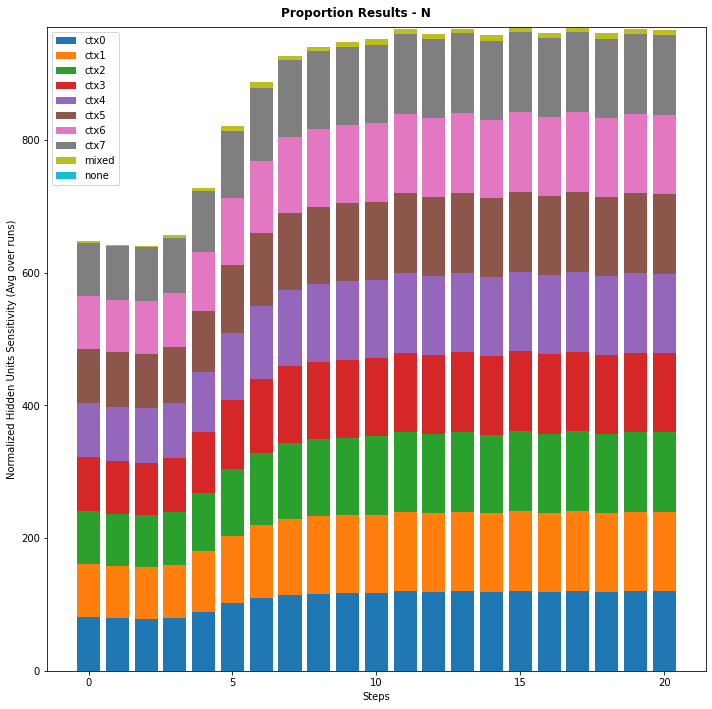

In [43]:
n = results['n']
ctxs = calc_hidd_sens(n)
m_ctxs = np.mean(ctxs, axis=0) # take avg over runs

# plot
fig, axs = plt.subplots(figsize=[10, 10])
ax = axs
# labels
labels = []
for ctx in range(n_ctxs):
    labels.append('ctx%s' %(ctx))
if n_ctxs==2:
    labels.append('none/mixed')
elif n_ctxs==4:
    labels.append('mixed')
    labels.append('none')
elif n_ctxs==8:
    labels.append('mixed')
    labels.append('none')
print(m_ctxs.shape)
for ctx in range(m_ctxs.shape[1]):
    ax.bar(range(n_cps), m_ctxs[:,ctx], bottom = np.sum(m_ctxs[:,:ctx], axis=1))
ax.legend(labels)
ax.set_xlabel('Steps')
ax.set_ylabel('Normalized Hidden Units Sensitivity (Avg over runs)')
fig.suptitle('Proportion Results - N', fontweight='bold')
plt.tight_layout()
fig_str = 'proportion_results_mlp_wine_n_%sctx_overCPs' %(n_ctxs)
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
              bbox_inches = 'tight', pad_inches = 0)


In [44]:
# # fake simulation for the bar chart
# temp = np.zeros([3,5,4])
# for r in range(temp.shape[0]):
#     for cp in range(temp.shape[1]):
#         for ctx in range(temp.shape[2]):
#             temp[r,cp,ctx] = ctx+1
# m_temp = np.mean(temp, axis=0)
# fig, axs = plt.subplots(figsize=[10, 10])
# ax = axs
# m_temp = np.mean(temp, axis=0)
# for ctx in range(temp.shape[2]):
#     ax.bar(range(temp.shape[1]), m_temp[:,ctx], bottom = np.sum(m_temp[:,:ctx], axis=1))


/Users/maryam/opt/anaconda3/envs/csls/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


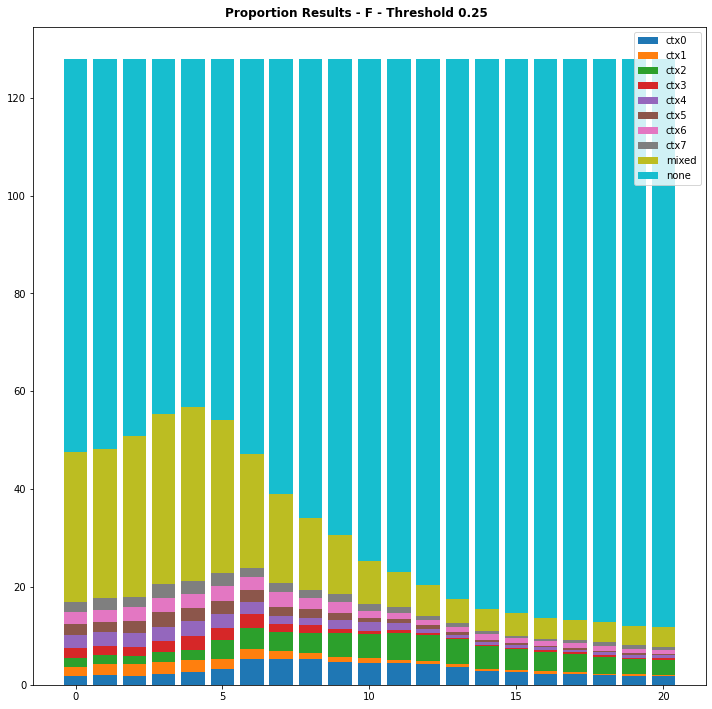

In [45]:
# first threshold, 
# then count
# then averge over those

# none here means none + mixed 
# given the overall activities for this hidd unit, the prop of trials that this unit was active that was above threshold (e.g, above 25%)
# n_ctxs=2, chance = 0.50, threshold = 95%
# n_ctxs=4, chance = 0.25,  threshold = 35%
# n_ctxs=8, chance = 0.125,  threshold = 25%
# labels
labels = []
for ctx in range(n_ctxs):
    labels.append('ctx%s' %(ctx))
if n_ctxs==2:
    n_thresh = 0.9
    labels.append('none/mixed')
    labels.append('none/mixed')
elif n_ctxs==4:
    n_thresh = 0.35
    labels.append('mixed')
    labels.append('none')
elif n_ctxs==8:
    n_thresh = 0.25
    labels.append('mixed')
    labels.append('none')

n = results['n']
f = n > n_thresh
ctxs = calc_hidd_sens(f)
m_ctxs = np.mean(ctxs, axis=0) # take avg over runs

# plot
fig, axs = plt.subplots(figsize=[10, 10])
ax = axs
for ctx in range(m_ctxs.shape[1]):
    ax.bar(range(n_cps), m_ctxs[:,ctx], bottom = np.sum(m_ctxs[:,:ctx], axis=1))
ax.legend(labels)
plt.tight_layout()
fig.suptitle('Proportion Results - F - Threshold %s' %(n_thresh), fontweight='bold')
plt.tight_layout()
fig_str = 'proportion_results_mlp_wine_f_%sctx_overCPs' %(n_ctxs)
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
              bbox_inches = 'tight', pad_inches = 0)

# n: [n_ctxs, hidden_dim] 
# normalized - for each ctx, for how many trials each unit was active (filtered by the threshold) 
# normalized by the overall activity of that unit for all ctx and trials
# we have ... many units that were active for ctx0 for more than n_threshold% of the trials


# normalized matrix

(8, 128)


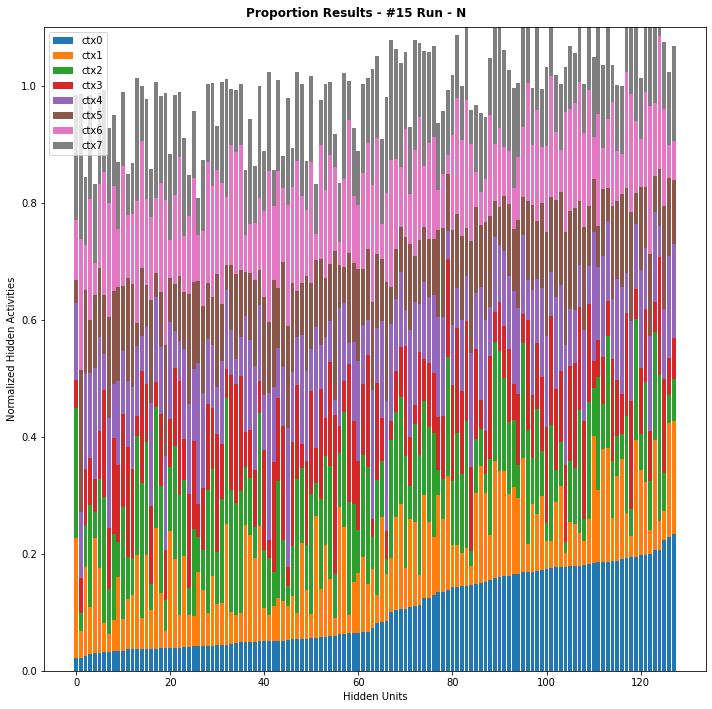

In [46]:
# plot 3P, using normalized p
n = results['n']
_,_,n_ctxs,hidd_dim = n.shape
n = n[w_run, w_cp, :, :]
sort_ind = 0
print(n.shape)
fig, axs = plt.subplots(figsize=[10, 10])
labels = []
ax = axs
for ctx in range(n_ctxs):
    labels.append('ctx%s' %(ctx))
# todo: sort the columns, based on the one context
n[sort_ind, :] = np.sort(n[sort_ind, :])
for ctx in range(n_ctxs):
    ax.bar(range(hidd_dim), n[ctx,:], bottom = np.sum(n[:ctx,:], axis=0))
    # ax.bar(range(n_cps), m_ctxs[:,ctx], bottom = np.sum(m_ctxs[:,:ctx], axis=1))

ax.set_ylim([0,1.1])
ax.set_xlabel('Hidden Units')
ax.set_ylabel('Normalized Hidden Activities')
ax.legend(labels)

fig.suptitle('Proportion Results - %s Run - N' %(run_label), fontweight='bold')
plt.tight_layout()
fig_str = 'proportion_results_mlp_wine_n_%sctx' %(n_ctxs)
fig.savefig(('../../figures/' + fig_str + '.pdf'), 
              bbox_inches = 'tight', pad_inches = 0)
# n: [n_ctxs, hidden_dim] 
# normalized - how much each unit is active for each ctx over trials 
# normalized by the overall activity of that unit for all ctx and trials
# x-axis shows each unit (128 hidden units total)
# y-axis shows normalized activity (number of trials) of that unit for each context over all the trials, 
# Q: what happens to those that were only active for the ctx1?